In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
def log_normal_standard(z):
    return -0.5 * (math.log(2 * math.pi) + z.pow(2)).flatten(1).sum(dim=1)

def bits_per_dim_from_logpx(log_px, C, H, W):
    D = C * H * W
    # correction dequantization (si tu dequantize avec /256)
    log_px = log_px - D * math.log(256.0)

    nll = -log_px.mean()  # TENSOR (important)
    bpd = nll / (math.log(2.0) * D)  # TENSOR
    return nll, bpd

def dequantize(x):
    # x in [0,1]
    x = x * 255.0
    x = x + torch.rand_like(x)
    x = x / 256.0
    return x

In [ ]:
def squeeze2x2(x):
    B, C, H, W = x.shape
    x = x.view(B, C, H//2, 2, W//2, 2)
    x = x.permute(0, 1, 3, 5, 2, 4).contiguous()
    return x.view(B, C*4, H//2, W//2)

def unsqueeze2x2(x):
    B, C, H, W = x.shape
    x = x.view(B, C//4, 2, 2, H, W)
    x = x.permute(0, 1, 4, 2, 5, 3).contiguous()
    return x.view(B, C//4, H*2, W*2)

In [ ]:
class ActNorm(nn.Module):
    def __init__(self, C, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.bias = nn.Parameter(torch.zeros(1, C, 1, 1))
        self.log_scale = nn.Parameter(torch.zeros(1, C, 1, 1))
        self.initialized = False

    @torch.no_grad()
    def initialize(self, x):
        mean = x.mean(dim=[0,2,3], keepdim=True)
        std = x.std(dim=[0,2,3], keepdim=True)
        self.bias.data = -mean
        self.log_scale.data = torch.log(1.0/(std + self.eps))
        self.initialized = True

    def forward(self, x):
        if self.training and (not self.initialized):
            self.initialize(x)
        y = (x + self.bias) * torch.exp(self.log_scale)
        B, C, H, W = x.shape
        logdet = (H*W) * self.log_scale.view(1, C).sum(dim=1)
        return y, logdet.expand(B)

    def inverse(self, y):
        return y * torch.exp(-self.log_scale) - self.bias

In [ ]:
class ChannelPermute(nn.Module):
    def __init__(self, C):
        super().__init__()
        perm = torch.randperm(C)
        inv = torch.empty_like(perm)
        inv[perm] = torch.arange(C)
        self.register_buffer("perm", perm)
        self.register_buffer("invperm", inv)

    def forward(self, x):
        # logdet = 0
        return x[:, self.perm, :, :], torch.zeros(x.size(0), device=x.device)

    def inverse(self, y):
        return y[:, self.invperm, :, :]

In [ ]:
class Invertible1x1Conv(nn.Module):
    def __init__(self, C):
        super().__init__()
        # orthogonal init
        w = torch.linalg.qr(torch.randn(C, C)).Q
        self.weight = nn.Parameter(w)

    def forward(self, x):
        B, C, H, W = x.shape
        Wmat = self.weight
        y = F.conv2d(x, Wmat.view(C, C, 1, 1))
        logdetW = torch.slogdet(Wmat)[1]
        logdet = (H*W) * logdetW
        return y, logdet.expand(B)

    def inverse(self, y):
        C = y.size(1)
        Winv = torch.inverse(self.weight)
        return F.conv2d(y, Winv.view(C, C, 1, 1))

In [ ]:
class CouplingNN(nn.Module):
    def __init__(self, in_ch, hidden_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, hidden_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_ch, hidden_ch, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_ch, out_ch, 3, padding=1),
        )
        nn.init.zeros_(self.net[-1].weight)
        nn.init.zeros_(self.net[-1].bias)

    def forward(self, x): return self.net(x)

class AffineCoupling(nn.Module):
    def __init__(self, C, hidden=64, clamp=2.0):
        super().__init__()
        assert C % 2 == 0
        self.nn = CouplingNN(C//2, hidden, C)  # outputs s,t for other half
        self.clamp = clamp

    def forward(self, x):
        x1, x2 = torch.chunk(x, 2, dim=1)
        h = self.nn(x1)
        s, t = torch.chunk(h, 2, dim=1)
        s = self.clamp * torch.tanh(s / self.clamp)

        y2 = x2 * torch.exp(s) + t
        y = torch.cat([x1, y2], dim=1)
        logdet = s.flatten(1).sum(dim=1)
        return y, logdet

    def inverse(self, y):
        y1, y2 = torch.chunk(y, 2, dim=1)
        h = self.nn(y1)
        s, t = torch.chunk(h, 2, dim=1)
        s = self.clamp * torch.tanh(s / self.clamp)

        x2 = (y2 - t) * torch.exp(-s)
        return torch.cat([y1, x2], dim=1)

In [ ]:
class FlowStep(nn.Module):
    def __init__(self, C, hidden=64, mixer="conv1x1"):
        super().__init__()
        self.actnorm = ActNorm(C)
        self.mixer = Invertible1x1Conv(C) if mixer == "conv1x1" else ChannelPermute(C)
        self.coupling = AffineCoupling(C, hidden=hidden)

    def forward(self, x):
        x, ld1 = self.actnorm(x)
        x, ld2 = self.mixer(x)
        x, ld3 = self.coupling(x)
        return x, (ld1 + ld2 + ld3)

    def inverse(self, z):
        z = self.coupling.inverse(z)
        z = self.mixer.inverse(z)
        z = self.actnorm.inverse(z)
        return z

In [ ]:
class GlowMiniMultiScale(nn.Module):
    """
    2-level multi-scale:
      Level1: squeeze -> K steps -> split (half to z1)
      Level2: squeeze -> K steps -> rest to z2
    """
    def __init__(self, K=4, hidden=64, mixer="conv1x1"):
        super().__init__()
        self.K = K
        self.hidden = hidden
        self.mixer = mixer

        # Level 1 operates on C=4 after squeeze
        self.level1 = nn.ModuleList([FlowStep(4, hidden, mixer=mixer) for _ in range(K)])
        # After split: keep 2 channels
        # Level 2: squeeze 2ch -> 8ch
        self.level2 = nn.ModuleList([FlowStep(8, hidden, mixer=mixer) for _ in range(K)])

    def forward(self, x):
        # x: (B,1,28,28)
        logdet_total = torch.zeros(x.size(0), device=x.device)

        # Level 1
        h = squeeze2x2(x)  # (B,4,14,14)
        for step in self.level1:
            h, ld = step(h)
            logdet_total += ld

        # split: z1 = first half channels, keep rest
        z1, h = torch.chunk(h, 2, dim=1)  # each (B,2,14,14)

        # Level 2
        h = squeeze2x2(h)  # (B,8,7,7)
        for step in self.level2:
            h, ld = step(h)
            logdet_total += ld

        z2 = h  # (B,8,7,7)

        # prior log prob (sum over all z parts)
        log_pz = log_normal_standard(z1) + log_normal_standard(z2)
        log_px = log_pz + logdet_total

        return (z1, z2), log_px

    def inverse(self, z1, z2):
        # invert Level 2
        h = z2
        for step in reversed(self.level2):
            h = step.inverse(h)
        h = unsqueeze2x2(h)  # (B,2,14,14)

        # concat with z1 to reconstruct Level1 output
        h = torch.cat([z1, h], dim=1)  # (B,4,14,14)

        # invert Level 1
        for step in reversed(self.level1):
            h = step.inverse(h)
        x = unsqueeze2x2(h)  # (B,1,28,28)
        return x

    @torch.no_grad()
    def sample(self, n, device, temperature=0.7):
        z1 = temperature * torch.randn(n, 2, 14, 14, device=device)
        z2 = temperature * torch.randn(n, 8, 7, 7, device=device)
        x = self.inverse(z1, z2)
        return x.clamp(0, 1)

    @torch.no_grad()
    def encode(self, x):
        (z1, z2), _ = self.forward(x)
        return z1, z2

    @torch.no_grad()
    def decode(self, z1, z2):
        return self.inverse(z1, z2)

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def train_one(model, loader, device, epochs=10, lr=1e-4):
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    for ep in range(epochs):
        model.train()
        bpd_running = 0.0

        for x, _ in loader:
            x = x.to(device)
            x = dequantize(x)

            (_, _), log_px = model(x)

            nll, bpd = bits_per_dim_from_logpx(log_px, C=1, H=28, W=28)

            opt.zero_grad(set_to_none=True)
            nll.backward()          # OK: nll est un tensor
            opt.step()

            bpd_running += bpd.item()  # OK: seulement pour print

        print(f"Epoch {ep+1} | bits/dim: {bpd_running/len(loader):.4f}")

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
ds = datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
loader = DataLoader(ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)

    # Model A: permute
model_perm = GlowMiniMultiScale(K=8, hidden=128, mixer="permute").to(device)
print("Training PERMUTE model")
train_one(model_perm, loader, device, epochs=25)

    # Model B: conv1x1
model_conv = GlowMiniMultiScale(K=8, hidden=128, mixer="conv1x1").to(device)
print("Training CONV1x1 model")
train_one(model_conv, loader, device, epochs=25)

    # sampling check
model_conv.eval()
samples = model_conv.sample(16, device)
print(samples.shape, samples.min().item(), samples.max().item())


Training PERMUTE model
Epoch 1 | bits/dim: 5.2727
Epoch 2 | bits/dim: 3.4078
Epoch 3 | bits/dim: 2.9463
Epoch 4 | bits/dim: 2.6784
Epoch 5 | bits/dim: 2.5169
Epoch 6 | bits/dim: 2.3959
Epoch 7 | bits/dim: 2.3193
Epoch 8 | bits/dim: 2.2234
Epoch 9 | bits/dim: 2.1624
Epoch 10 | bits/dim: 2.1252
Epoch 11 | bits/dim: 2.0908
Epoch 12 | bits/dim: 2.0343
Epoch 13 | bits/dim: 2.0192
Epoch 14 | bits/dim: 1.9830
Epoch 15 | bits/dim: 1.9622
Epoch 16 | bits/dim: 1.9700
Epoch 17 | bits/dim: 1.9280
Epoch 18 | bits/dim: 1.9163
Epoch 19 | bits/dim: 1.9101
Epoch 20 | bits/dim: 1.8921
Epoch 21 | bits/dim: 1.8809
Epoch 22 | bits/dim: 1.8783
Epoch 23 | bits/dim: 1.8728
Epoch 24 | bits/dim: 1.8535
Epoch 25 | bits/dim: 1.8529
Training CONV1x1 model
Epoch 1 | bits/dim: 5.8746
Epoch 2 | bits/dim: 4.5586
Epoch 3 | bits/dim: 3.5487
Epoch 4 | bits/dim: 3.2819
Epoch 5 | bits/dim: 3.1102
Epoch 6 | bits/dim: 2.9612
Epoch 7 | bits/dim: 2.8310
Epoch 8 | bits/dim: 2.7236
Epoch 9 | bits/dim: 2.6269
Epoch 10 | bits/dim:

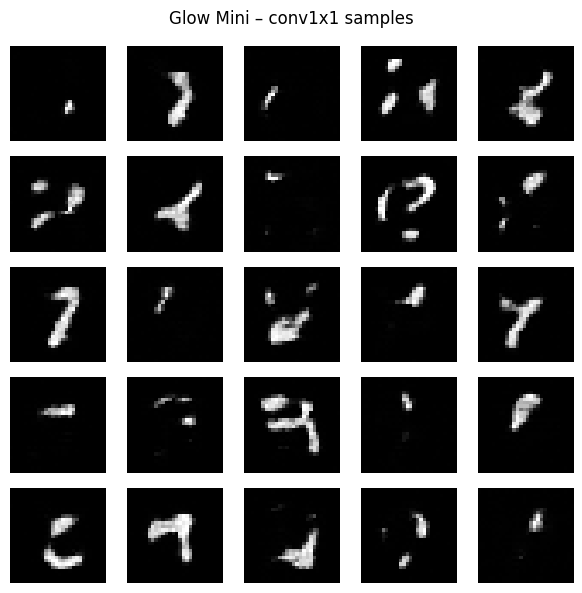

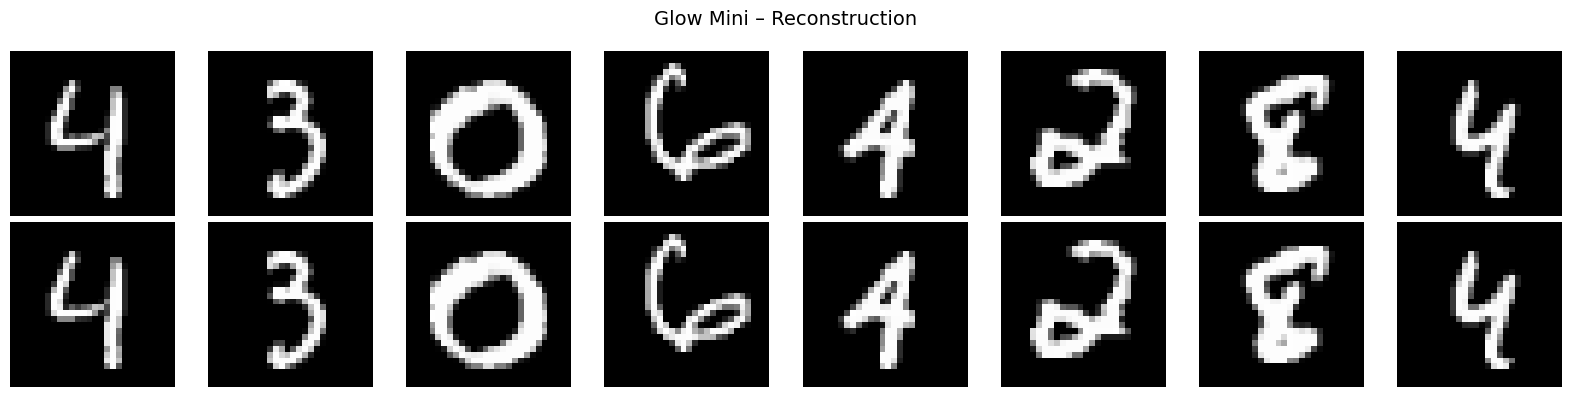

In [ ]:
import torch
import matplotlib.pyplot as plt
import math

@torch.no_grad()
def reconstruct_and_show(model, loader, device, n=8):
    """
    Affiche n images originales (ligne 1)
    et leurs reconstructions Glow (ligne 2)
    """
    model.eval()

    # prendre un batch
    x, _ = next(iter(loader))
    x = x[:n].to(device)

    # encode -> decode
    z1, z2 = model.encode(x)
    x_rec = model.decode(z1, z2).clamp(0.0, 1.0)

    # passage CPU pour matplotlib
    x = x.cpu()
    x_rec = x_rec.cpu()

    # plot
    fig, axes = plt.subplots(2, n, figsize=(2*n, 4))

    for i in range(n):
        axes[0, i].imshow(x[i, 0], cmap="gray")
        axes[0, i].axis("off")

        axes[1, i].imshow(x_rec[i, 0], cmap="gray")
        axes[1, i].axis("off")

    axes[0, 0].set_ylabel("Original", fontsize=12)
    axes[1, 0].set_ylabel("Reconstruction", fontsize=12)

    plt.suptitle("Glow Mini – Reconstruction", fontsize=14)
    plt.tight_layout()
    plt.show()


@torch.no_grad()
def generate_and_show(model, n_samples, device, title="Generated samples"):
    model.eval()

    # Génération
    x = model.sample(n_samples, device)  # (B,1,28,28)
    x = x.cpu().numpy()

    # Grille carrée
    grid_size = math.ceil(math.sqrt(n_samples))

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(6, 6))
    fig.suptitle(title)

    idx = 0
    for i in range(grid_size):
        for j in range(grid_size):
            ax = axes[i, j]
            ax.axis("off")

            if idx < n_samples:
                ax.imshow(x[idx, 0], cmap="gray")
            idx += 1

    plt.tight_layout()
    plt.show()


# X = nombre d'images à générer
generate_and_show(
    model=model_conv,   # ou model_perm
    n_samples=25,
    device=device,
    title="Glow Mini – conv1x1 samples"
)
reconstruct_and_show(model_conv, loader, device, n=8)